In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
import warnings
warnings.filterwarnings("ignore")

<b>Import dataset</b>

In [4]:
missing_value=["Undefined"]
data_path = "hotel_bookings.csv"
df_hotel = pd.read_csv(data_path, na_values=missing_value)

In [5]:
df_hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [6]:
df_hotel.shape

(119390, 32)

In [7]:
df_hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

<b>Creating a new column by combining the year, month and date of arrival together.</b>

In [8]:
df_hotel['arrival_date'] = pd.to_datetime(df_hotel.arrival_date_year.astype(str) + '/' + df_hotel.arrival_date_month.astype(str) + '/' + df_hotel.arrival_date_day_of_month.astype(str))

In [9]:
df_hotel['arrival_date']

0        2015-07-01
1        2015-07-01
2        2015-07-01
3        2015-07-01
4        2015-07-01
            ...    
119385   2017-08-30
119386   2017-08-31
119387   2017-08-31
119388   2017-08-31
119389   2017-08-29
Name: arrival_date, Length: 119390, dtype: datetime64[ns]

In [10]:
df_hotel['arrival_date'][0]

Timestamp('2015-07-01 00:00:00')

<b>Checking how many missing values each column contains</b>

In [11]:
np.sum(df_hotel.isnull())

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                1169
country                              488
market_segment                         2
distribution_channel                   5
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

<b>Drop columns we don't need</b>

In [12]:
df_hotel.drop(columns=["arrival_date_year", "arrival_date_month", "arrival_date_day_of_month", "company", "meal"],
           inplace=True)

In [14]:
df_hotel.head()

,hotel,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,country,...,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,0,342,27,0,0,2,0.0,0,PRT,...,No Deposit,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01
1,Resort Hotel,0,737,27,0,0,2,0.0,0,PRT,...,No Deposit,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01
2,Resort Hotel,0,7,27,0,1,1,0.0,0,GBR,...,No Deposit,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
3,Resort Hotel,0,13,27,0,1,1,0.0,0,GBR,...,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
4,Resort Hotel,0,14,27,0,2,2,0.0,0,GBR,...,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01


<b>Filling missing values in agent column</b>

In [15]:
nan_replacement_dict = {"children": 0 ,"country" : "UKNWN", 'agent' : 0.0, 'company' : 0}
df_hotel.fillna(nan_replacement_dict, inplace = True)

In [16]:
df_hotel.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_week_number          0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
country                           0
market_segment                    2
distribution_channel              5
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status                0
reservation_status_date           0
arrival_date                

<b>Data grouping and aggregation</b>

<b>Average stays during week and on weekends</b>

In [18]:
df_hotel.stays_in_weekend_nights.mean()

0.9275986263506156

In [19]:
df_hotel.stays_in_week_nights.mean()

2.500301532791691

<b>Group by hotel</b>

In [20]:
df_hotel.groupby('hotel').stays_in_week_nights.mean()

hotel
City Hotel      2.182957
Resort Hotel    3.128732
Name: stays_in_week_nights, dtype: float64

<b>Converting datetime columns</b>

In [21]:
df_hotel['reservation_status_date'] = df_hotel['reservation_status_date'].astype('datetime64')

In [22]:
df_hotel['arrival_date'] = df_hotel['arrival_date'].astype('datetime64')

<b>Categorical columns</b>

In [23]:
categoricals = [i for i in df_hotel.columns if df_hotel.dtypes[i] == 'object']
print("Categorical Columns are: ", *categoricals, sep = '\n')

Categorical Columns are: 
hotel
country
market_segment
distribution_channel
reserved_room_type
assigned_room_type
deposit_type
customer_type
reservation_status


In [24]:
for i in categoricals:
    print(("{} : {} Total nunique = {} \n").format(i, df_hotel[i].unique(), df_hotel[i].nunique()))

hotel : ['Resort Hotel' 'City Hotel'] Total nunique = 2 

country : ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' 'UKNWN' 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM'
 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY'
 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN'
 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB'
 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI'
 'SAU' 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL' 'UZB'
 'NPL' 'BHS' 'MAC' 'TGO' 'TWN' 'DJI' 'STP' 'KNA' 'ETH' 'IRQ' 'HND' 'RWA'
 'KHM' 'MCO' 'BGD' 'IMN' 'TJK' 'NIC' 'BEN' 'VGB' 'TZA' 'GAB' 'GHA' 'TMP'
 'GLP' 'KEN' 'LIE' 'GNB' 'MNE' 'UMI' 'MYT' 'FRO' 'MMR' 

<b>Numerical columnns</b>

In [25]:
numericals = [i for i in df_hotel.columns if df_hotel.dtypes[i] != 'object']
print("Numerical Columns are: ", *numericals, sep = '\n')

Numerical Columns are: 
is_canceled
lead_time
arrival_date_week_number
stays_in_weekend_nights
stays_in_week_nights
adults
children
babies
is_repeated_guest
previous_cancellations
previous_bookings_not_canceled
booking_changes
agent
days_in_waiting_list
adr
required_car_parking_spaces
total_of_special_requests
reservation_status_date
arrival_date


In [26]:
sns.color_palette("Set2", 6)

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961)]

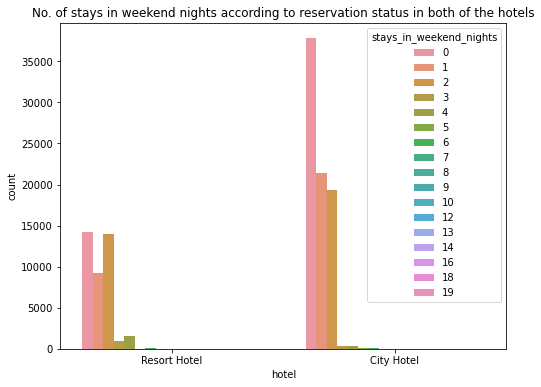

In [32]:
sns.set_palette('Set2')
plt.figure(figsize = (8,6))
sns.countplot(x = 'hotel', data = df_hotel, hue = 'stays_in_weekend_nights')
plt.title("No. of stays in weekend nights according to reservation status in both of the hotels")
plt.show()

There are more stays in weekend nights at the hotels than cancelled reservations. There are very few no-shows.

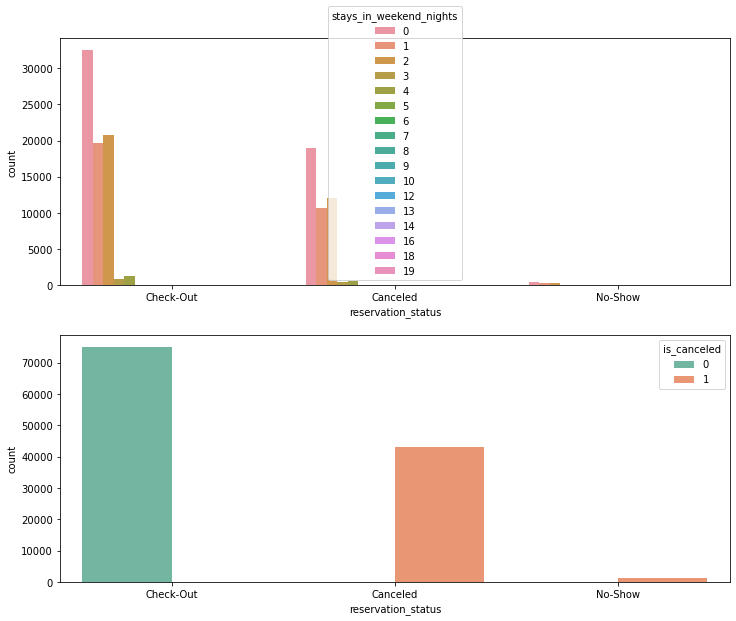

In [36]:
_, ax = plt.subplots( nrows = 2, ncols = 1, figsize = (12,10))
sns.countplot(x = 'reservation_status', data = df_hotel, hue = 'stays_in_weekend_nights', ax = ax[0])
sns.countplot(x ='reservation_status', data = df_hotel, hue = 'is_canceled', ax = ax[1])
plt.show()

City Hotel has more cancellations than Resort Hotel.

<b>Preprocessing</b>

In [38]:
df_hotel.drop(['reservation_status', 
'reservation_status_date' , 'arrival_date_week_number',  'arrival_date', 'agent'], axis = 1, inplace = True)
df_hotel.shape

(119390, 23)

In [39]:
#Copy of a dataframe
df_hotel_1 = df_hotel.copy()

In [40]:
hotel = {'Resort Hotel': 0, 'City Hotel' : 1}

In [41]:
df_hotel_1['hotel'] = df_hotel_1['hotel'].map(hotel)

In [42]:
df_hotel_1 = pd.get_dummies(data = df_hotel_1, columns = [ 'market_segment', 'distribution_channel','reserved_room_type', 'assigned_room_type', 'customer_type', 'deposit_type'], drop_first = True)

In [43]:
LE = LabelEncoder()

In [44]:
df_hotel_1['country'] = LE.fit_transform(df_hotel_1['country'])

In [45]:
df_hotel_1.head()

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,country,is_repeated_guest,...,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,deposit_type_Non Refund,deposit_type_Refundable
0,0,0,342,0,0,2,0.0,0,135,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,737,0,0,2,0.0,0,135,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,7,0,1,1,0.0,0,59,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,13,0,1,1,0.0,0,59,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,14,0,2,2,0.0,0,59,0,...,0,0,0,0,0,0,1,0,0,0


<b>Separate training and target datasets</b>

In [46]:
X = df_hotel_1.drop('is_canceled', axis = 1)
y = df_hotel_1['is_canceled']

In [47]:
X_train,  X_test,y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 40)

<b>Set global random state</b>

In [48]:
global random_state
random_state = 40

<b>Dictionary of classification models</b>

In [50]:
model_dict = {
    'LOR_Model' : LogisticRegression(n_jobs = -1),
    'KNN_Model' : KNeighborsClassifier(),
    'RFC_Model' : RandomForestClassifier(n_jobs = -1),
}  

In [51]:
def model_1(algorithm, X_train, X_test, y_train, y_test):
    alg = algorithm
    alg_model = alg.fit(X_train, y_train)
    global y_pred
    y_pred = alg_model.predict(X_test)
    
    print('Accuracy Score: {}\n\nConfusion Matrix:\n {}'
      .format(accuracy_score(y_test,y_pred), confusion_matrix(y_test,y_pred)))

In [52]:
for name, model in model_dict.items():
    print("\n")
    print(name, "\n")
    model_1(model, X_train, X_test, y_train, y_test )



LOR_Model 

Accuracy Score: 0.7921657313566184

Confusion Matrix:
 [[20573  2140]
 [ 5304  7800]]


KNN_Model 

Accuracy Score: 0.7888432867074294

Confusion Matrix:
 [[19348  3365]
 [ 4198  8906]]


RFC_Model 

Accuracy Score: 0.8766786721389285

Confusion Matrix:
 [[20970  1743]
 [ 2674 10430]]


<b>Conclusion:</b>

Random Forest Classifier is the best algorithm to predict the cancellation.
It provides 88% accuracy.